Dyad Comparison (by author role)
===

Goal:
 - Do certain author role pairs reciprocate more? (Logistic regression)
 - Do certain author role pairs last longer than others? (Survival analysis)
 - Do certain author roles have more interactions? (Linear regression)
 
A next step: does the network structure have implications for the length of time that a relationship lasts?

---

Later edit: NoPatientLinks means no links in the interaction network between the initiator and the receiver if the receiver was a patient and hadn't yet authored on the receiving site.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os
import re
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
import sqlite3
from tqdm import tqdm
import random
import pickle
from datetime import datetime
import bisect

import matplotlib.pyplot as plt
import matplotlib.dates as md
import matplotlib
import pylab as pl
from IPython.core.display import display, HTML

import networkx as nx
import scipy.stats

In [3]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [4]:
working_dir = "/home/srivbane/shared/caringbridge/data/projects/sna-social-support/dyad_growth"
assert os.path.exists(working_dir)

In [5]:
git_root_dir = !git rev-parse --show-toplevel
git_root_dir = git_root_dir[0]
figures_dir = os.path.join(git_root_dir, 'figures')
figures_dir

'/panfs/roc/groups/3/srivbane/levon003/repos/sna-social-support/figures'

In [6]:
start_date = datetime.fromisoformat('2005-01-01')
start_timestamp = int(start_date.timestamp() * 1000)
end_date = datetime.fromisoformat('2016-06-01')
end_timestamp = int(end_date.timestamp() * 1000)
subset_start_date = datetime.fromisoformat('2014-01-01')
subset_start_timestamp = int(subset_start_date.timestamp() * 1000)

### Read in the data

In [7]:
# load the list of valid users
data_selection_working_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_user_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_user_ids.txt"), 'r') as infile:
    for line in infile:
        user_id = line.strip()
        if user_id == "":
            continue
        else:
            valid_user_ids.add(int(user_id))
len(valid_user_ids)

362345

In [8]:
# load the list of valid sites
data_selection_working_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/data_selection"
valid_site_ids = set()
with open(os.path.join(data_selection_working_dir, "valid_site_ids.txt"), 'r') as infile:
    for line in infile:
        site_id = line.strip()
        if site_id == "":
            continue
        else:
            valid_site_ids.add(int(site_id))
len(valid_site_ids)

411269

In [9]:
# read the journal metadata with author type info added
s = datetime.now()
author_type_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/author_type"
journal_metadata_filepath = os.path.join(author_type_dir, "journal_metadata_with_author_type.df")
journal_df = pd.read_feather(journal_metadata_filepath)
print(datetime.now() - s)
len(journal_df)

0:00:18.528654


15850052

In [10]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
# note that only 41 updates have this issue
invalid_created_at = journal_df.created_at <= 0
journal_df.loc[invalid_created_at, 'created_at'] = journal_df.loc[invalid_created_at, 'updated_at']

In [11]:
health_cond_filepath = os.path.join("/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata", "assigned_health_conditions.feather")
user_health_conds_df = pd.read_feather(health_cond_filepath)
len(user_health_conds_df)

714874

In [12]:
np.sum(user_health_conds_df[user_health_conds_df.user_id.isin(valid_user_ids)].assigned_health_cond != 'None') / len(user_health_conds_df[user_health_conds_df.user_id.isin(valid_user_ids)])

0.5782527701499952

In [13]:
for cond, count in Counter(user_health_conds_df[user_health_conds_df.user_id.isin(valid_user_ids)].assigned_health_cond).most_common():
    print(f"{cond} & {count:,} & {count/len(valid_user_ids)*100:.2f}\\% \\\\")

None & 152,818 & 42.17\% \\
Cancer & 109,339 & 30.18\% \\
Other & 37,556 & 10.36\% \\
Surgery/Transplantation & 15,415 & 4.25\% \\
Injury & 12,910 & 3.56\% \\
Cardiovascular/Stroke & 12,685 & 3.50\% \\
Neurological Condition & 9,376 & 2.59\% \\
Infant/Childbirth & 7,952 & 2.19\% \\
Condition Unknown & 2,252 & 0.62\% \\
Congenital/Immune Disorder & 2,042 & 0.56\% \\


In [14]:
# read the user author type dataframe
author_type_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/author_type"
user_patient_proportions_filepath = os.path.join(author_type_dir, 'user_patient_proportions.df')
user_df = pd.read_feather(user_patient_proportions_filepath)
len(user_df)

362345

In [15]:
# read the user->user interactions dataframe
metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata"
u2u_df = pd.read_feather(os.path.join(metadata_dir,"u2u_df.feather"))
len(u2u_df)

11424980

In [16]:
# read the site-level metadata
site_metadata_working_dir = "/home/lana/shared/caringbridge/data/derived/site_metadata"
site_metadata_filepath = os.path.join(site_metadata_working_dir, "site_metadata.feather")
site_metadata_df = pd.read_feather(site_metadata_filepath)
len(site_metadata_df)

840943

In [17]:
# percent of valid sites that self-report a health condition
site_subset = site_metadata_df[site_metadata_df.site_id.isin(valid_site_ids)]
np.sum(site_subset.healthCondition_category.notnull()) / len(site_subset)

0.5335096980321882

In [18]:
# currently not necessary, since we use the processed user->user interactions...
# read in the interactions dataframe
#metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata"
#author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
#ints_df = pd.read_hdf(author_to_site)
#len(ints_df)

## Filter to only valid users and sort data

Also create initiations dataframe

In [19]:
user_df = user_df[user_df.user_id.isin(valid_user_ids)]
len(user_df)

362345

In [20]:
u2u_df = u2u_df[(u2u_df.from_user_id.isin(valid_user_ids))&(u2u_df.to_user_id.isin(valid_user_ids))]
len(u2u_df)

10102765

In [21]:
u2u_df = u2u_df.sort_values(by='created_at', ascending=True)
init_df = u2u_df.drop_duplicates(subset=['from_user_id', 'to_user_id'], keep='first')

In [22]:
u2u_df.head()

,from_user_id,to_user_id,created_at,int_type
10441828,23616609,20085865,1101191820000,amps
8318309,10499159,20085865,1101191820000,amps
8318310,10499159,20085865,1102603140000,amps
2155775,1217109,1,1103856900000,amps
7519,122,48,1117645589000,guestbook


## Forming relationships and labeling them

In [23]:
dyad_ids_dict = {}
dyad_ids_list = []
global_dyad_counter = 0
for row in tqdm(init_df.itertuples(), total=len(init_df)):
    tup = (row.from_user_id, row.to_user_id)
    r_tup = (row.to_user_id, row.from_user_id)
    if r_tup in dyad_ids_dict:
        dyad_id = dyad_ids_dict[r_tup]
        dyad_ids_dict[tup] = dyad_id
    else:
        dyad_id = global_dyad_counter
        global_dyad_counter += 1
        dyad_ids_dict[tup] = dyad_id
    dyad_ids_list.append(dyad_id)

100%|██████████| 932616/932616 [00:02<00:00, 355374.63it/s]


In [24]:
all_ints_dyad_ids_list = []
for row in tqdm(u2u_df.itertuples(), total=len(u2u_df)):
    tup = (row.from_user_id, row.to_user_id)
    dyad_id = dyad_ids_dict[tup]
    all_ints_dyad_ids_list.append(dyad_id)

100%|██████████| 10102765/10102765 [00:25<00:00, 392761.31it/s]


In [25]:
u2u_df['dyad_id'] = all_ints_dyad_ids_list

In [26]:
#def create_dyad_row(group):
dyad_groups = u2u_df.groupby(by='dyad_id', sort=False)
#.apply()

In [27]:
group_data = []
for dyad_id, group in tqdm(dyad_groups):
    data = group.values
    from_user_id = data[:,0]
    #to_user_id 	created_at 	int_type
    initiator_user_id = from_user_id[0]
    reciprocator_user_id = None
    is_reciprocated = False
    int_count = len(from_user_id)
    created_at = data[:,2]
    first_int = created_at[0]
    last_int = created_at[-1]
    
    user_set = set(from_user_id)
    if int_count > 1 and len(user_set) > 1:
        is_reciprocated = True
        user_set.remove(initiator_user_id)
        reciprocator_user_id = user_set.pop()
        
        int_type_list = data[:,3].tolist()
        created_at_list = created_at.tolist()
        initiator_ints_list = from_user_id == initiator_user_id
        initiator_int_count = np.sum(initiator_ints_list)
        reciprocator_int_count = int_count - initiator_int_count
    else:
        int_type_list = []
        created_at_list = []
        initiator_ints_list = [True for i in range(int_count)]
        initiator_int_count = int_count
        reciprocator_int_count = 0
    
    d = {
        'initiator_user_id': initiator_user_id,
        'reciprocator_user_id': reciprocator_user_id,
        'is_reciprocated': is_reciprocated,
        'int_count': int_count,
        'first_int': first_int,
        'last_int': last_int,
        'initiator_int_count': initiator_int_count,
        'reciprocator_int_count': reciprocator_int_count,
        'int_type_list': int_type_list,
        'created_at_list': created_at_list,
        'initiator_ints_list': initiator_ints_list
    }
    group_data.append(d)

100%|██████████| 809076/809076 [04:57<00:00, 2719.61it/s]


In [28]:
dyad_df = pd.DataFrame(group_data)
len(dyad_df)

809076

In [29]:
# not sure why this n is larger than the reciprocal analysis regression...
len(dyad_df[(dyad_df.initiator_user_id.isin(valid_user_ids))&(~dyad_df.is_reciprocated)])

685536

In [30]:
# of all initiations, this is the percent that are reciprocated
np.sum(dyad_df.is_reciprocated), np.sum(dyad_df.is_reciprocated) / len(dyad_df)

(123540, 0.1526927013037094)

In [31]:
first_reciprocator_int_times = []
for row in tqdm(dyad_df.itertuples(), total=len(dyad_df)):
    if row.is_reciprocated:
        ind = row.initiator_ints_list.tolist().index(False)
        first_reciprocator_int = row.created_at_list[ind]
    else:
        first_reciprocator_int = -1
    first_reciprocator_int_times.append(first_reciprocator_int)

100%|██████████| 809076/809076 [00:02<00:00, 369207.15it/s]


In [32]:
first_reciprocator_int_times = np.array(first_reciprocator_int_times)

In [33]:
# of initiations that occurred in the analysis period, 7.5\% are initiated
dyad_subset = dyad_df[(dyad_df.first_int >= subset_start_timestamp)&(dyad_df.first_int <= end_timestamp)]
np.sum(dyad_subset.is_reciprocated) / len(dyad_subset), len(dyad_subset)

(0.07596781862315757, 159844)

In [34]:
np.sum(dyad_subset.is_reciprocated)

12143

In [35]:
# of initiations that occurred in the analysis period, 7.5\% are initiated
dyad_subset = dyad_df[((dyad_df.first_int >= subset_start_timestamp)&(dyad_df.first_int <= end_timestamp))
    |((first_reciprocator_int_times >= subset_start_timestamp)&(first_reciprocator_int_times <= end_timestamp))]
np.sum(dyad_subset.is_reciprocated) / len(dyad_subset), len(dyad_subset)

(0.13536154170374187, 170824)

In [36]:
rel_df = dyad_df[dyad_df.is_reciprocated].copy()
len(rel_df)

123540

In [37]:
rel_df['duration_months'] = (rel_df.last_int - rel_df.first_int) / (1000 * 60 * 60 * 24 * 30)

In [38]:
author_type_dict = {row.user_id: row.user_author_type for row in user_df.itertuples()}
rel_df['initiator_author_type'] = rel_df.initiator_user_id.map(lambda user_id: author_type_dict[user_id])
rel_df['reciprocator_author_type'] = rel_df.reciprocator_user_id.map(lambda user_id: author_type_dict[user_id])

In [39]:
rel_df['pct_initiator_ints'] = rel_df.initiator_int_count / rel_df.int_count

In [40]:
rel_df.head(n=2)

,initiator_user_id,reciprocator_user_id,is_reciprocated,int_count,first_int,last_int,initiator_int_count,reciprocator_int_count,int_type_list,created_at_list,initiator_ints_list,duration_months,initiator_author_type,reciprocator_author_type,pct_initiator_ints
8,386,28.0,True,168,1117710956000,1238549181000,34,134,"[guestbook, guestbook, guestbook, guestbook, g...","[1117710956000, 1118835728000, 1119181337000, ...","[True, True, True, True, True, True, True, Tru...",46.619686,mixed,cg,0.202381
13,597,486.0,True,9,1117747707000,1194404419000,7,2,"[guestbook, guestbook, guestbook, guestbook, g...","[1117747707000, 1120831206000, 1121130818000, ...","[True, True, True, True, True, True, True, Fal...",29.574349,cg,p,0.777778


#### Quantiles

Descriptive analysis during revisions.

In [41]:
np.median(rel_df.int_count)

13.0

In [42]:
np.sum(rel_df.int_count == 2), np.sum(rel_df.int_count == 2) / len(rel_df)

(7048, 0.05705034806540392)

In [43]:
np.sum(rel_df.int_count <= 100), np.sum(rel_df.int_count <= 100) / len(rel_df)

(115676, 0.9363445038044358)

In [44]:
np.quantile(rel_df.int_count, 0.1), np.quantile(rel_df.int_count, 0.9)

(3.0, 71.0)

Finished creating columns for "relationships" i.e. reciprocated dyads

#### Descriptive analysis

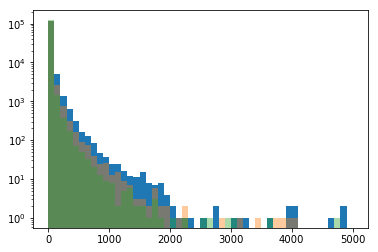

In [45]:
# distribution of number of interactions
plt.hist(rel_df.int_count, log=True, bins=50, range=(0, 5000))
plt.hist(rel_df.initiator_int_count, log=True, bins=50, range=(0, 5000), alpha=0.4)
plt.hist(rel_df.reciprocator_int_count, log=True, bins=50, range=(0, 5000), alpha=0.4)
plt.show()

In [46]:
# no real difference in average number of interactions by initiator
sample1 = rel_df[rel_df.initiator_author_type == 'p'].int_count
sample2 = rel_df[rel_df.initiator_author_type == 'cg'].int_count

np.mean(sample1), \
np.mean(sample2), \
np.mean(sample2) - np.mean(sample1), \
scipy.stats.ttest_ind(sample1, sample2, equal_var=False)

(33.658281874318924,
 34.55403925348287,
 0.8957573791639462,
 Ttest_indResult(statistic=-0.7569860550940949, pvalue=0.4490652850444252))

In [47]:
# relationships initiated by caregivers are longer on average
# but this is hard to tease apart without a survival analysis
sample1 = rel_df[rel_df.initiator_author_type == 'p'].duration_months
sample2 = rel_df[rel_df.initiator_author_type == 'cg'].duration_months

np.mean(sample1), \
np.mean(sample2), \
np.mean(sample2) - np.mean(sample1), \
scipy.stats.ttest_ind(sample1, sample2, equal_var=False)

(26.505515510892234,
 27.688912993066875,
 1.183397482174641,
 Ttest_indResult(statistic=-6.229963455150991, pvalue=4.71968693530892e-10))

In [48]:
# should probably investigate these relationships with huge numbers of interactions
rel_df[rel_df.int_count > 5000]

,initiator_user_id,reciprocator_user_id,is_reciprocated,int_count,first_int,last_int,initiator_int_count,reciprocator_int_count,int_type_list,created_at_list,initiator_ints_list,duration_months,initiator_author_type,reciprocator_author_type,pct_initiator_ints
212651,1939017,3666823.0,True,9676,1244782225000,1544013214000,2875,6801,"[guestbook, guestbook, guestbook, guestbook, g...","[1244782225000, 1244782225000, 1246063413000, ...","[True, True, False, False, False, False, False...",115.444054,p,cg,0.297127
226519,3295808,3241154.0,True,8331,1250131903000,1386103411000,832,7499,"[guestbook, guestbook, guestbook, guestbook, g...","[1250131903000, 1250131903000, 1250131903000, ...","[True, True, True, False, False, False, False,...",52.458144,cg,cg,0.099868
229704,1939017,3295808.0,True,18340,1251259893000,1549782830000,16116,2224,"[guestbook, guestbook, guestbook, guestbook, g...","[1251259893000, 1251259893000, 1251259893000, ...","[True, True, True, True, True, True, False, Fa...",115.170886,p,cg,0.878735
230731,3295808,5485367.0,True,6424,1251587853000,1546217831000,1703,4721,"[guestbook, guestbook, guestbook, guestbook, g...","[1251587853000, 1251600004000, 1251600004000, ...","[True, False, False, False, False, False, Fals...",113.668973,cg,mixed,0.265100
245682,5611265,3295808.0,True,5078,1256495633000,1492377712000,5077,1,"[guestbook, guestbook, guestbook, guestbook, g...","[1256495633000, 1256495633000, 1256495633000, ...","[True, True, True, True, True, True, True, Tru...",91.003889,p,cg,0.999803


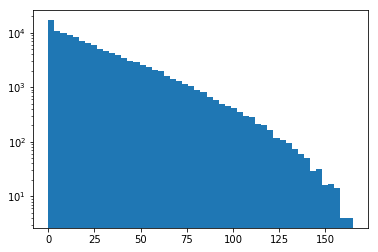

In [49]:
# distribution of relationship distribution
plt.hist(rel_df.duration_months, log=True, bins=50)
plt.show()

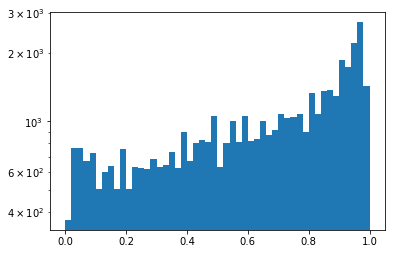

In [50]:
# distribution of relationship "balance"
plt.hist(rel_df[rel_df.int_count >= 20].pct_initiator_ints, log=True, bins=50)
plt.show()

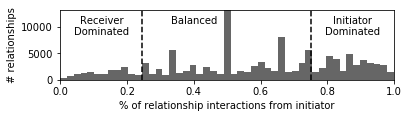

In [51]:
# generate the distribution of the relationship balance as a figure for the paper
fig, ax = plt.subplots(1, 1, figsize=(5.47807, 1.5))
bins = np.linspace(0, 1, num=50)
counts, edges, _ = ax.hist(rel_df.pct_initiator_ints, bins=bins, log=False, color='black', alpha=0.6)
plt.axvline(0.245, color='black', linestyle="--")
plt.axvline(0.751, color='black', linestyle="--")
plt.text(0.4, np.max(counts) * 0.93, 'Balanced', verticalalignment='top', horizontalalignment='center')
plt.text(0.125, np.max(counts) * 0.93, 'Receiver\nDominated', verticalalignment='top', horizontalalignment='center')
plt.text(0.75 + 0.125, np.max(counts) * 0.93, 'Initiator\nDominated', verticalalignment='top', horizontalalignment='center')
ax.set_xlabel("% of relationship interactions from initiator")
ax.set_ylabel("# relationships")

plt.tight_layout(pad=0.2)
plt.margins(0,0)
fig.savefig(fname=os.path.join(figures_dir,"pct_balance_distribution.pdf"), dpi=200, bbox_inches='tight', pad_inches = 0)     
plt.show()

In [52]:
np.sum(rel_df.is_reciprocated) / len(rel_df)

1.0

## Active time features

Computes the total time active on CB

In [53]:
# read in the interactions dataframe
metadata_dir = "/home/lana/shared/caringbridge/data/projects/sna-social-support/user_metadata"
author_to_site = os.path.join(metadata_dir, "interaction_metadata.h5")
ints_df = pd.read_hdf(author_to_site)
len(ints_df)

28388948

In [54]:
# as a quick fix for invalid dates in journals, when created_at is 0 we use the updated_at instead
invalid_created_at = ints_df.created_at <= 0
print(np.sum(invalid_created_at))
ints_df.loc[invalid_created_at, 'created_at'] = ints_df.loc[invalid_created_at, 'updated_at']
print(np.sum(ints_df.created_at <= 0))

44
0


In [55]:
# compute total time on site
# for each user, this is from the very first interaction to the last interaction
s = datetime.now()
total_time_on_site = ints_df[ints_df.user_id.isin(valid_user_ids)].groupby(by='user_id').agg({
    'created_at': np.ptp
}).created_at.rename('total_time_on_site')
total_time_on_site_dict = total_time_on_site.to_dict()
print(datetime.now() - s)
len(total_time_on_site_dict)

0:00:44.516837


362345

In [56]:
# compute first and last recorded update for each user
s = datetime.now()
first_int_time = ints_df[ints_df.user_id.isin(valid_user_ids)].groupby(by='user_id').agg({
    'created_at': np.min
}).created_at
first_int_time_dict = first_int_time.to_dict()
last_int_time = ints_df[ints_df.user_id.isin(valid_user_ids)].groupby(by='user_id').agg({
    'created_at': np.max
}).created_at
last_int_time_dict = last_int_time.to_dict()
print(datetime.now() - s)
len(first_int_time_dict)

0:00:22.900708


362345

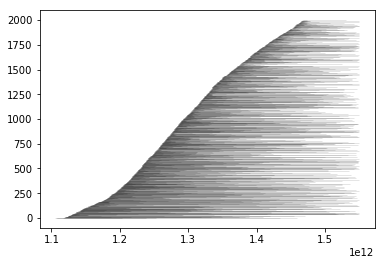

In [57]:
# randomly show some activity timelines, just for fun
tdf = pd.DataFrame(first_int_time)
tdf = tdf.rename(columns={'created_at': 'first_int_time'})
tdf['last_int_time'] = last_int_time
ys = []
xmins = []
xmaxs = []
sample = tdf[tdf.first_int_time > start_timestamp].sample(n=2000)
for i, row in enumerate(sample.sort_values(by='first_int_time', ascending=True).itertuples()):
    xmins.append(row.first_int_time)
    xmaxs.append(row.last_int_time)
    ys.append(i)
plt.hlines(ys, xmins, xmaxs, alpha=0.1, linewidth=1)
plt.show()

In [58]:
# key question: what should the threshold be for "maybe censored?"
# the write for life paper uses 90 days
# so the question becomes: what number of users active in the 90 days
end_of_data_timestamp = np.max(ints_df[ints_df.int_type == 'guestbook'].created_at)
print(datetime.utcfromtimestamp(end_of_data_timestamp / 1000))
threshold_ms = 1000 * 60 * 60 * 24 * 30 * 6 # 6 months
print(datetime.utcfromtimestamp((end_of_data_timestamp - threshold_ms)/ 1000))

2016-06-01 21:07:43
2015-12-04 21:07:43


In [59]:
tdf = pd.DataFrame(first_int_time)
tdf = tdf.rename(columns={'created_at': 'first_int_time'})
tdf['last_int_time'] = last_int_time

In [60]:
# number of valid users that joined CB before the cutoff but posted in the cutoff
# in other words, these are the ACTUALLY censored users
censored_count = np.sum(tdf[tdf.first_int_time <= end_of_data_timestamp - threshold_ms].last_int_time > end_of_data_timestamp - threshold_ms)
censored_count

96376

In [61]:
with tqdm(total=len(last_int_time)) as prog:
    def get_prethreshold_max(created_at):
        prog.update(1)
        prethreshold_idx = created_at <= end_of_data_timestamp - threshold_ms
        if np.sum(prethreshold_idx) == 0:
            return -1
        else:
            return np.max(created_at[prethreshold_idx])
    
    last_int_time_prethreshold = ints_df[
        ints_df.user_id.isin(valid_user_ids)
                                    ].groupby(by='user_id').agg({
        'created_at': get_prethreshold_max
    }).created_at.rename('last_int_time_prethreshold')

100%|██████████| 362345/362345 [04:51<00:00, 1243.17it/s]


In [62]:
assert len(tdf) == len(last_int_time_prethreshold)
tdf['last_int_time_prethreshold'] = last_int_time_prethreshold

In [63]:
no_int_prethreshold = tdf.last_int_time_prethreshold == -1
first_int_postthreshold = tdf.first_int_time >= end_of_data_timestamp - threshold_ms
assert np.all(no_int_prethreshold == first_int_postthreshold)

In [64]:
prethreshold_users = tdf[tdf.first_int_time <= end_of_data_timestamp - threshold_ms]
censored_users = prethreshold_users.last_int_time > end_of_data_timestamp - threshold_ms
considered_censored_users = (prethreshold_users.first_int_time >= end_of_data_timestamp - threshold_ms - threshold_ms)\
|(prethreshold_users.last_int_time_prethreshold >= end_of_data_timestamp - threshold_ms - threshold_ms)
np.sum(censored_users), np.sum(considered_censored_users)

(96376, 67474)

In [65]:
len(prethreshold_users), len(prethreshold_users) / len(tdf)

(347914, 0.9601733154866219)

In [66]:
# recall: what pct of the ACTUALLY censored users are considered to be censored?
# With a 6-month threshold, we miss more than HALF of the users who are censored, concluding that they
# are not in fact censored. (After all, their last update was more than 6 months before the end of data collection)
np.sum(considered_censored_users[censored_users]) / np.sum(censored_users)

0.49538266788412055

In [67]:
# precision: what pct of the considered censored users are actually censored?
np.sum(considered_censored_users[censored_users]) / np.sum(considered_censored_users)

0.7075762515932063

This analysis is immensely depressing, since it suggests we essentially can't tell if a user will post again. (Lots of users who haven't posted for six months will post again!)

What we would like to do is make a claim about the difference between patient-initiated and caregiver-initiated relationships: that they are longer or shorter.


## Regression modeling of interaction count (Poisson)

Note: this requires only the rel_df to be computed.

In [68]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [69]:
rel_df.head(n=1)

,initiator_user_id,reciprocator_user_id,is_reciprocated,int_count,first_int,last_int,initiator_int_count,reciprocator_int_count,int_type_list,created_at_list,initiator_ints_list,duration_months,initiator_author_type,reciprocator_author_type,pct_initiator_ints
8,386,28.0,True,168,1117710956000,1238549181000,34,134,"[guestbook, guestbook, guestbook, guestbook, g...","[1117710956000, 1118835728000, 1119181337000, ...","[True, True, True, True, True, True, True, Tru...",46.619686,mixed,cg,0.202381


In [70]:
rel_df['balance'] = 'balanced'
rel_df.loc[rel_df.pct_initiator_ints >= 0.75, 'balance'] = 'initiator'
rel_df.loc[rel_df.pct_initiator_ints <= 0.25, 'balance'] = 'reciprocator'

In [71]:
rel_df['is_balanced'] = (rel_df.balance == 'balanced').astype(int)
rel_df['is_author_type_shared'] = (rel_df.initiator_author_type == rel_df.reciprocator_author_type).astype(int)

In [72]:
# 52.47\% of relationships are balanced using the indicated thresholds.
np.sum(rel_df.balance == 'balanced') / len(rel_df)

0.5253521126760563

In [73]:
rel_df['pct_initiator_ints_scaled'] = rel_df.pct_initiator_ints * 100

In [74]:
np.quantile(rel_df.int_count, 0.99)

339.0

In [75]:
rel_df_subset = rel_df[rel_df.int_count <= 344]
len(rel_df_subset), len(rel_df_subset) / len(rel_df)

(122330, 0.9902056014246398)

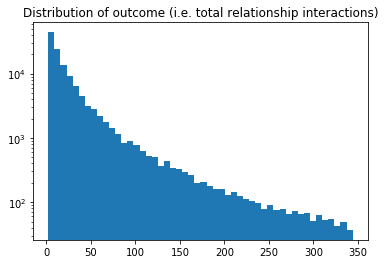

In [76]:
# counts follow a power law, as expected...
# but that makes transformation to normality problematic
plt.hist(rel_df_subset.int_count, bins=50, log=True)
plt.title("Distribution of outcome (i.e. total relationship interactions)")
plt.show()

In [77]:
f = f'int_count ~ C(initiator_author_type) + C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              int_count   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     2558.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:03:59   Log-Likelihood:            -6.2151e+05
No. Observations:              122330   AIC:                         1.243e+06
Df Residuals:                  122323   BIC:                         1.243e+06
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
========================================================================================================
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------
Intercept                                6.4343      0.315     20.452      0.000       5.818       7.051
C(initiator_author_type)[T.mixed]       -0.7173      0.411     -1.746      0.081      -1.523       0.088
C(initiator_author_type)[T.p]           -0.9487      0.307     -3.087      0.002      -1.551      -0.346
C(reciprocator_author_type)[T.mixed]    -1.3945      0.414     -3.370      0.001      -2.205      -0.583
C(reciprocator_author_type)[T.p]        -0.5863      0.322     -1.822      0.069      -1.217       0.045
pct_initiator_ints_scaled                0.1310      0.004     29.990      0.000       0.122       0.140
duration_months                          0.5288      0.004    120.744      0.000       0.520       0.537
==============================================================================
Omnibus:                    88588.911   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1525162.765
Skew:                           3.388   Prob(JB):                         0.00
Kurtosis:                      18.916   Cond. No.                         273.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [78]:
# ANOVA for an interaction
# this is significant
import statsmodels.stats
md0 = smf.ols('int_count ~ C(initiator_author_type) + C(reciprocator_author_type)', data=rel_df_subset).fit()
md1 = smf.ols('int_count ~ C(initiator_author_type) + C(reciprocator_author_type) + duration_months', data=rel_df_subset).fit()
md2 = smf.ols('int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + duration_months', data=rel_df_subset).fit()

anovaResults = statsmodels.stats.anova.anova_lm(md0, md1, md2, typ=1)
print(anovaResults)

   df_resid           ssr  df_diff       ss_diff             F        Pr(>F)
0  122325.0  2.084892e+08      0.0           NaN           NaN           NaN
1  122324.0  1.867227e+08      1.0  2.176647e+07  14270.177865  0.000000e+00
2  122320.0  1.865762e+08      4.0  1.465293e+05     24.016288  6.887403e-20


/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


In [79]:
f = f'np.log(int_count) ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()

log_linear_preds = res.predict(rel_df_subset)

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      np.log(int_count)   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     2623.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:04:04   Log-Likelihood:            -1.7786e+05
No. Observations:              122330   AIC:                         3.557e+05
Df Residuals:                  122319   BIC:                         3.558e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  1.8381      0.008    218.377      0.000       1.822       1.855
C(initiator_author_type)[T.mixed]                                         -0.0161      0.013     -1.228      0.219      -0.042       0.010
C(initiator_author_type)[T.p]                                             -0.0790      0.010     -7.560      0.000      -0.099      -0.059
C(reciprocator_author_type)[T.mixed]                                      -0.0383      0.014     -2.810      0.005      -0.065      -0.012
C(reciprocator_author_type)[T.p]                                          -0.0231      0.011     -2.017      0.044      -0.046      -0.001
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0646      0.035      1.862      0.063      -0.003       0.133
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1838      0.027      6.829      0.000       0.131       0.237
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1110      0.028      3.916      0.000       0.055       0.167
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2688      0.019     14.199      0.000       0.232       0.306
pct_initiator_ints_scaled                                                  0.0054      0.000     46.825      0.000       0.005       0.006
duration_months                                                            0.0182      0.000    155.894      0.000       0.018       0.018
==============================================================================
Omnibus:                     1442.664   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1427.846
Skew:                           0.245   Prob(JB):                    8.86e-311
Kurtosis:                       2.799   Cond. No.                         872.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [80]:
np.exp(res.params)

Intercept                                                                 6.284649
C(initiator_author_type)[T.mixed]                                         0.983980
C(initiator_author_type)[T.p]                                             0.924028
C(reciprocator_author_type)[T.mixed]                                      0.962423
C(reciprocator_author_type)[T.p]                                          0.977146
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]    1.066755
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]        1.201806
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]        1.117440
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]            1.308349
pct_initiator_ints_scaled                                                 1.005457
duration_months                                                           1.018333
dtype: float64

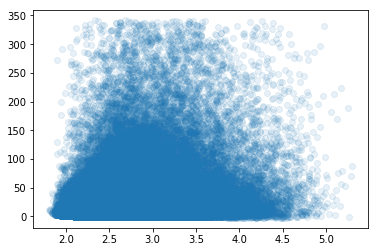

In [81]:
resid = rel_df_subset.int_count - log_linear_preds
plt.scatter(log_linear_preds, resid, alpha=0.1)
plt.show()

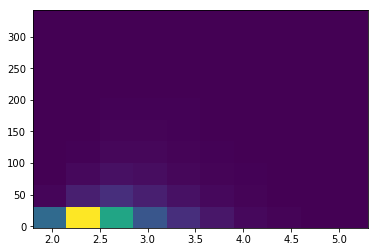

In [82]:
resid = rel_df_subset.int_count - log_linear_preds
plt.hist2d(log_linear_preds, resid)
plt.show()

In [83]:
f = f'int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              int_count   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     1546.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:04:07   Log-Likelihood:            -6.2146e+05
No. Observations:              122330   AIC:                         1.243e+06
Df Residuals:                  122319   BIC:                         1.243e+06
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
==========================================================================================================================================
                                                                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  6.7311      0.316     21.284      0.000       6.111       7.351
C(initiator_author_type)[T.mixed]                                         -1.2250      0.494     -2.479      0.013      -2.193      -0.257
C(initiator_author_type)[T.p]                                             -3.3060      0.393     -8.418      0.000      -4.076      -2.536
C(reciprocator_author_type)[T.mixed]                                      -2.6215      0.512     -5.119      0.000      -3.625      -1.618
C(reciprocator_author_type)[T.p]                                          -2.9369      0.431     -6.818      0.000      -3.781      -2.093
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     2.1442      1.304      1.644      0.100      -0.412       4.700
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         5.2252      1.011      5.166      0.000       3.243       7.208
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         2.7026      1.065      2.537      0.011       0.614       4.791
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             6.6280      0.711      9.320      0.000       5.234       8.022
pct_initiator_ints_scaled                                                  0.1311      0.004     30.023      0.000       0.123       0.140
duration_months                                                            0.5295      0.004    120.941      0.000       0.521       0.538
==============================================================================
Omnibus:                    88617.263   Durbin-Watson:                   1.893
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1527583.459
Skew:                           3.389   Prob(JB):                         0.00
Kurtosis:                      18.930   Cond. No.                         872.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

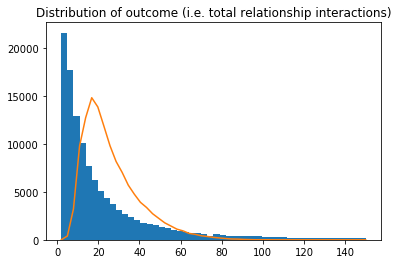

array([    5,   395,  3223,  9767, 12720, 14804, 13845, 11843,  9804,
        8165,  7021,  5698,  4751,  3905,  3371,  2718,  2239,  1767,
        1437,  1109,   929,   667,   568,   418,   345,   253,   194,
         133,    85,    71,    39,    22,     6,     8,     5,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0])

In [84]:
# linear model fit to the data, consistently overestimates
linear_preds = res.predict(rel_df_subset)
_, bins, _ = plt.hist(rel_df_subset.int_count, bins=50, log=False, range=(2, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions)")
pred_density, _ = np.histogram(linear_preds, bins=bins)
#bins = np.linspace(2, 300, num=300)
#pred_density, _ = np.histogram(preds, bins=bins)
plt.plot(bins, pred_density.tolist() + [0,])
plt.show()
pred_density

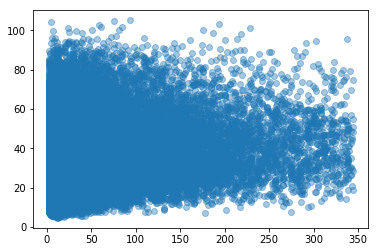

In [85]:
plt.scatter(rel_df_subset.int_count, linear_preds, alpha=0.4)
plt.show()

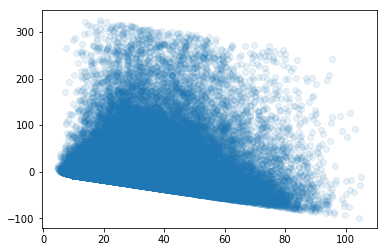

In [86]:
resid = rel_df_subset.int_count - linear_preds
plt.scatter(linear_preds, resid, alpha=0.1)
plt.show()

In [87]:
#for line in res.summary2().as_latex().split("\n"):
#    line = line.replace("\_", "-").replace("_", "-")
#    print(line)

In [88]:
f = f'int_count ~ is_author_type_shared + pct_initiator_ints_scaled + duration_months'
#rel_df_subset.loc[:, 'is_author_type_shared'] = (rel_df_subset.initiator_author_type == rel_df_subset.reciprocator_author_type).astype(int)
model = smf.ols(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              int_count   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     5144.
Date:                Mon, 01 Jun 2020   Prob (F-statistic):               0.00
Time:                        16:04:11   Log-Likelihood:            -6.2147e+05
No. Observations:              122330   AIC:                         1.243e+06
Df Residuals:                  122326   BIC:                         1.243e+06
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.2785      0.345     12.400      0.000       3.602       4.955
is_author_type_shared         2.4786      0.240     10.307      0.000       2.007       2.950
pct_initiator_ints_scaled     0.1310      0.004     30.009      0.000       0.122       0.140
duration_months               0.5292      0.004    120.944      0.000       0.521       0.538
==============================================================================
Omnibus:                    88606.058   Durbin-Watson:                   1.894
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1526758.061
Skew:                           3.389   Prob(JB):                         0.00
Kurtosis:                      18.925   Cond. No.                         229.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Actually doing Poisson regression

In [89]:
f = f'int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'

model = smf.poisson(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

Optimization terminated successfully.
         Current function value: 17.877967
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                          Poisson Regression Results                          
==============================================================================
Dep. Variable:              int_count   No. Observations:               122330
Model:                        Poisson   Df Residuals:                   122319
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                  0.1391
Time:                        16:04:13   Log-Likelihood:            -2.1870e+06
converged:                       True   LL-Null:                   -2.5403e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.6095      0.002   1633.235      0.000       2.606       2.613
C(initiator_author_type)[T.mixed]                                         -0.0488      0.002    -19.888      0.000      -0.054      -0.044
C(initiator_author_type)[T.p]                                             -0.1165      0.002    -59.060      0.000      -0.120      -0.113
C(reciprocator_author_type)[T.mixed]                                      -0.0932      0.003    -36.363      0.000      -0.098      -0.088
C(reciprocator_author_type)[T.p]                                          -0.1042      0.002    -47.686      0.000      -0.108      -0.100
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0718      0.007     10.903      0.000       0.059       0.085
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1871      0.005     37.488      0.000       0.177       0.197
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1081      0.005     20.125      0.000       0.098       0.119
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2393      0.004     67.145      0.000       0.232       0.246
pct_initiator_ints_scaled                                                  0.0045   2.09e-05    215.369      0.000       0.004       0.005
duration_months                                                            0.0146   1.66e-05    878.807      0.000       0.015       0.015
==========================================================================================================================================
"""

In [90]:
np.exp(res.params)

Intercept                                                                 13.591770
C(initiator_author_type)[T.mixed]                                          0.952372
C(initiator_author_type)[T.p]                                              0.889994
C(reciprocator_author_type)[T.mixed]                                       0.911019
C(reciprocator_author_type)[T.p]                                           0.901079
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     1.074420
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         1.205692
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         1.114106
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             1.270329
pct_initiator_ints_scaled                                                  1.004518
duration_months                                                            1.014723
dtype: float64

In [91]:
# dispersion is assumed to be 1 by poisson regression
res.scale

1.0

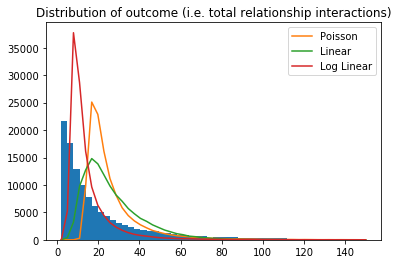

array([    0,     0,     0,   282,  9783, 25101, 22867, 16146, 11150,
        8120,  5836,  4415,  3447,  2733,  2187,  1697,  1387,  1117,
         914,   739,   632,   562,   392,   432,   282,   266,   228,
         207,   147,   175,   131,   121,   108,    78,    85,    72,
          67,    57,    49,    29,    42,    33,    23,    20,    24,
          16,    22,    16,    14,    10])

In [92]:
# the poisson model consistently overestimates the counts
_, bins, _ = plt.hist(rel_df_subset.int_count, bins=50, log=False, range=(2, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions)")
poisson_preds = res.predict(rel_df_subset)
pred_density, _ = np.histogram(poisson_preds, bins=bins)
#bins = np.linspace(2, 300, num=300)
#pred_density, _ = np.histogram(preds, bins=bins)
plt.plot(bins, pred_density.tolist() + [0,], label='Poisson')

#
linear_pred_density, _ = np.histogram(linear_preds, bins=bins)
plt.plot(bins, linear_pred_density.tolist() + [0,], label='Linear')

log_linear_pred_density, _ = np.histogram(np.exp(log_linear_preds), bins=bins)
plt.plot(bins, log_linear_pred_density.tolist() + [0,], label='Log Linear')


plt.legend()

plt.show()
pred_density

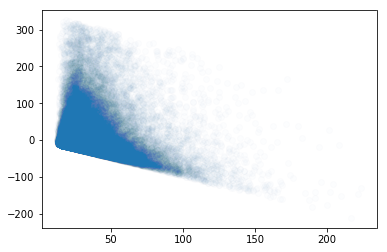

In [93]:
resid = rel_df_subset.int_count - poisson_preds
plt.scatter(poisson_preds, resid, alpha=0.01)
plt.show()

In [94]:
f = f'int_count_beyond_initial ~ C(initiator_author_type) * C(reciprocator_author_type) + pct_initiator_ints_scaled + duration_months'
rel_df_subset['int_count_beyond_initial'] = rel_df_subset.int_count - 2
model = smf.poisson(formula=f, data = rel_df_subset)
res = model.fit()
res.summary()

/home/srivbane/shared/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Optimization terminated successfully.
         Current function value: 19.124200
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                             Poisson Regression Results                             
====================================================================================
Dep. Variable:     int_count_beyond_initial   No. Observations:               122330
Model:                              Poisson   Df Residuals:                   122319
Method:                                 MLE   Df Model:                           10
Date:                      Mon, 01 Jun 2020   Pseudo R-squ.:                  0.1386
Time:                              16:04:18   Log-Likelihood:            -2.3395e+06
converged:                             True   LL-Null:                   -2.7160e+06
Covariance Type:                  nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.4815      0.002   1491.318      0.000       2.478       2.485
C(initiator_author_type)[T.mixed]                                         -0.0529      0.003    -20.743      0.000      -0.058      -0.048
C(initiator_author_type)[T.p]                                             -0.1254      0.002    -61.050      0.000      -0.129      -0.121
C(reciprocator_author_type)[T.mixed]                                      -0.1003      0.003    -37.630      0.000      -0.106      -0.095
C(reciprocator_author_type)[T.p]                                          -0.1122      0.002    -49.304      0.000      -0.117      -0.108
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0769      0.007     11.215      0.000       0.063       0.090
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.2015      0.005     38.869      0.000       0.191       0.212
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1173      0.006     20.989      0.000       0.106       0.128
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2579      0.004     69.563      0.000       0.251       0.265
pct_initiator_ints_scaled                                                  0.0048   2.17e-05    223.032      0.000       0.005       0.005
duration_months                                                            0.0155    1.7e-05    910.204      0.000       0.015       0.016
==========================================================================================================================================
"""

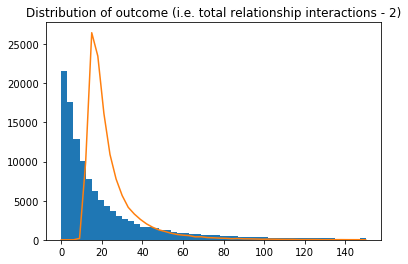

array([    0,     0,     0,   179,  9892, 26472, 23487, 16148, 10909,
        7775,  5657,  4147,  3293,  2603,  2037,  1608,  1277,  1072,
         847,   686,   592,   537,   379,   390,   283,   257,   214,
         193,   141,   170,   126,   120,   101,    75,    86,    74,
          61,    52,    56,    34,    32,    35,    32,    15,    21,
          20,    22,    16,    14,    14])

In [95]:
# the poisson model consistently overestimates the counts
preds = res.predict(rel_df_subset)
_, bins, _ = plt.hist(rel_df_subset.int_count_beyond_initial, bins=50, log=False, range=(0, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions - 2)")
pred_density, _ = np.histogram(preds, bins=bins)
#bins = np.linspace(2, 300, num=300)
#pred_density, _ = np.histogram(preds, bins=bins)
plt.plot(bins, pred_density.tolist() + [0,])
plt.show()
pred_density

In [96]:
# negative binomial model
f = f'int_count ~ C(initiator_author_type) * C(reciprocator_author_type) + is_balanced + duration_months'

model = smf.negativebinomial(formula=f, data = rel_df_subset)
res = model.fit(maxiter=100)
res.summary()

Optimization terminated successfully.
         Current function value: 4.219275
         Iterations: 47
         Function evaluations: 54
         Gradient evaluations: 54


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:              int_count   No. Observations:               122330
Model:               NegativeBinomial   Df Residuals:                   122319
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.02748
Time:                        16:04:28   Log-Likelihood:            -5.1614e+05
converged:                       True   LL-Null:                   -5.3073e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  2.8557      0.006    466.822      0.000       2.844       2.868
C(initiator_author_type)[T.mixed]                                         -0.0174      0.013     -1.386      0.166      -0.042       0.007
C(initiator_author_type)[T.p]                                             -0.0802      0.010     -8.008      0.000      -0.100      -0.061
C(reciprocator_author_type)[T.mixed]                                      -0.0463      0.013     -3.547      0.000      -0.072      -0.021
C(reciprocator_author_type)[T.p]                                          -0.0627      0.011     -5.710      0.000      -0.084      -0.041
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.0481      0.033      1.448      0.148      -0.017       0.113
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.1850      0.026      7.190      0.000       0.135       0.235
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.0752      0.027      2.771      0.006       0.022       0.128
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2422      0.018     13.367      0.000       0.207       0.278
is_balanced                                                               -0.3523      0.006    -62.068      0.000      -0.363      -0.341
duration_months                                                            0.0199      0.000    149.301      0.000       0.020       0.020
alpha                                                                      0.9353      0.004    262.883      0.000       0.928       0.942
==========================================================================================================================================
"""

In [97]:
# these are the incidence rate ratios
np.exp(res.params)

Intercept                                                                 17.386507
C(initiator_author_type)[T.mixed]                                          0.982704
C(initiator_author_type)[T.p]                                              0.922970
C(reciprocator_author_type)[T.mixed]                                       0.954790
C(reciprocator_author_type)[T.p]                                           0.939208
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     1.049283
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         1.203272
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         1.078115
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             1.274067
is_balanced                                                                0.703047
duration_months                                                            1.020095
alpha                                                                      2

In [98]:
# initiating patient
1 - np.exp(-0.074763)

0.07203661240791681

In [99]:
# receiver patient
1 - np.exp(-0.055339)

0.05383565613230756

In [100]:
# initiating and receiving patient
np.exp(-0.074763 -0.055339 + 0.232120) - 1

0.10740340480982158

In [101]:
for line in res.summary2().as_latex().split("\n")[17:13+25]:
    line = line.replace("\_", "-").replace("_", "-")
    line = re.sub('\s+', ' ', line).strip()
    print(line)

\begin{tabular}{lcccccc}
\hline
& Coef. & Std.Err. & z & P$> |$z$|$ & [0.025 & 0.975] \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept & 2.8557 & 0.0061 & 466.8221 & 0.0000 & 2.8437 & 2.8677 \\
C(initiator-author-type)[T.mixed] & -0.0174 & 0.0126 & -1.3863 & 0.1657 & -0.0421 & 0.0072 \\
C(initiator-author-type)[T.p] & -0.0802 & 0.0100 & -8.0075 & 0.0000 & -0.0998 & -0.0605 \\
C(reciprocator-author-type)[T.mixed] & -0.0463 & 0.0130 & -3.5470 & 0.0004 & -0.0718 & -0.0207 \\
C(reciprocator-author-type)[T.p] & -0.0627 & 0.0110 & -5.7097 & 0.0000 & -0.0842 & -0.0412 \\
C(initiator-author-type)[T.mixed]:C(reciprocator-author-type)[T.mixed] & 0.0481 & 0.0332 & 1.4482 & 0.1476 & -0.0170 & 0.1132 \\
C(initiator-author-type)[T.p]:C(reciprocator-author-type)[T.mixed] & 0.1850 & 0.0257 & 7.1898 & 0.0000 & 0.1346 & 0.2355 \\
C(initiator-author-type)[T.mixed]:C(reciprocator-author-type)[T.p] & 0.0752 & 0.0271 & 2.7714 & 0.0056 & 0.0220 & 0.1284 \\
C(initiator-author-type)[T.p]:C(rec

[Predicted counts](https://stats.stackexchange.com/questions/17006/interpretation-of-incidence-rate-ratios) for 6-month, perfectly balanced relationships.

Computed with a slightly older version of the model that used a different balance control var, but the same approach works for computing predicted counts at a particular number of months.

```
# p init, p receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 1 - 0.0372 * 1 + 0.1894 * 1)
17.18608423066515
# p init, cg receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 1 - 0.0372 * 0 + 0.1894 * 0)
14.75969271221521
# cg init, p receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 0 - 0.0372 * 1 + 0.1894 * 0)
15.23354646085602
# cg init, cg receiver
>>> np.exp(2.4489 + 0.0038 * 50 + 0.0203 * 6 - 0.0688 * 0 - 0.0372 * 0 + 0.1894 * 0)
15.810906710189084
```

In [102]:
nb_preds = res.predict(rel_df_subset)

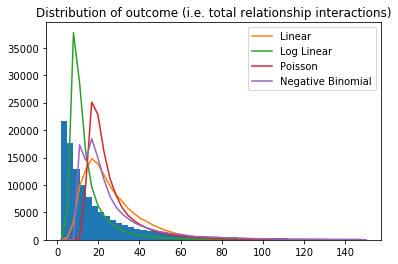

array([    0,     0,     0,   179,  9892, 26472, 23487, 16148, 10909,
        7775,  5657,  4147,  3293,  2603,  2037,  1608,  1277,  1072,
         847,   686,   592,   537,   379,   390,   283,   257,   214,
         193,   141,   170,   126,   120,   101,    75,    86,    74,
          61,    52,    56,    34,    32,    35,    32,    15,    21,
          20,    22,    16,    14,    14])

In [103]:
# of the four models tried, it looks like the negative binomial model is the best fit
# although, 
_, bins, _ = plt.hist(rel_df_subset.int_count, bins=50, log=False, range=(2, 150))
plt.title("Distribution of outcome (i.e. total relationship interactions)")

linear_pred_density, _ = np.histogram(linear_preds, bins=bins)
plt.plot(bins, linear_pred_density.tolist() + [0,], label='Linear')

log_linear_pred_density, _ = np.histogram(np.exp(log_linear_preds), bins=bins)
plt.plot(bins, log_linear_pred_density.tolist() + [0,], label='Log Linear')

poisson_pred_density, _ = np.histogram(poisson_preds, bins=bins)
plt.plot(bins, poisson_pred_density.tolist() + [0,], label='Poisson')

nb_pred_density, _ = np.histogram(nb_preds, bins=bins)
plt.plot(bins, nb_pred_density.tolist() + [0,], label='Negative Binomial')

plt.legend()

plt.show()
pred_density

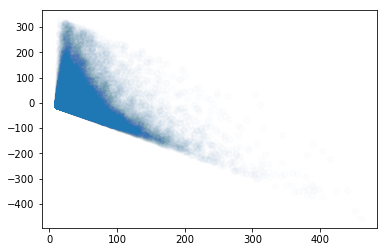

In [104]:
resid = rel_df_subset.int_count - nb_preds
plt.scatter(nb_preds, resid, alpha=0.01)
plt.show()

In [105]:
for line in res.summary2().as_latex().split("\n"):
    line = line.replace("\_", "-").replace("_", "-")
    print(line)

\begin{table}
\caption{Results: NegativeBinomial}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & NegativeBinomial & Pseudo R-squared: & 0.027         \\
Dependent Variable: & int-count       & AIC:              & 1032311.9041  \\
Date:               & 2020-06-01 16:04 & BIC:              & 1032428.4778  \\
No. Observations:   & 122330           & Log-Likelihood:   & -5.1614e+05   \\
Df Model:           & 10               & LL-Null:          & -5.3073e+05   \\
Df Residuals:       & 122319           & LLR p-value:      & 0.0000        \\
Converged:          & 1.0000           & Scale:            & 1.0000        \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                                                           &  Coef.  & Std.Err. &    z     & P$> |$z$|$ &  [0.025 &  0.975]  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept                                                                  &

## Relationship "balance" analysis

In [106]:
rel_df['balance'] = 'balanced'
rel_df.loc[rel_df.pct_initiator_ints >= 0.75, 'balance'] = 'initiator'
rel_df.loc[rel_df.pct_initiator_ints <= 0.25, 'balance'] = 'reciprocator'

In [107]:
for rel_type, count in Counter(rel_df.balance).most_common():
    print(f"{rel_type:>20} {count} {count / len(rel_df) * 100:.2f}%")

            balanced 64902 52.54%
           initiator 40521 32.80%
        reciprocator 18117 14.66%


In [108]:
np.sum(rel_df[rel_df.int_count > 10].pct_initiator_ints > 0.5) / len(rel_df[rel_df.int_count > 10])

0.6308438056010871

In [109]:
for initiator in ['p', 'cg']:
    for reciprocator in ['p', 'cg']:
        rel_df_subset = rel_df[(rel_df.initiator_author_type == initiator)&(rel_df.reciprocator_author_type == reciprocator)]
        print(initiator, reciprocator)
        for rel_type, count in Counter(rel_df_subset.balance).most_common():
            print(f"{rel_type:>20} {count} {count / len(rel_df_subset) * 100:.2f}%")

p p
            balanced 4549 55.62%
           initiator 2484 30.37%
        reciprocator 1145 14.00%
p cg
            balanced 5760 50.47%
           initiator 3920 34.35%
        reciprocator 1732 15.18%
cg p
            balanced 4681 50.74%
           initiator 3058 33.15%
        reciprocator 1486 16.11%
cg cg
            balanced 40246 53.11%
           initiator 24609 32.48%
        reciprocator 10919 14.41%


In [110]:
# when initiator and receiver share an author type, relationship is more likely to be balanced
sample1 = (rel_df[rel_df.initiator_author_type == rel_df.reciprocator_author_type].balance == 'balanced').astype(int)
sample2 = (rel_df[rel_df.initiator_author_type != rel_df.reciprocator_author_type].balance == 'balanced').astype(int)

np.mean(sample1), \
np.mean(sample2), \
np.mean(sample1) - np.mean(sample2), \
scipy.stats.ttest_ind(sample1, sample2, equal_var=False)

(0.5335297155196695,
 0.5071741625795679,
 0.026355552940101612,
 Ttest_indResult(statistic=8.577261178979912, pvalue=9.900679172694287e-18))

In [111]:
rel_df['is_balanced'] = (rel_df.balance == 'balanced').astype(int)

In [112]:
def print_feature_summary(res):
    for feature, coef in zip(res.params.index, res.params):
        prob = np.exp(coef)/(1+np.exp(coef))
        feature_name = feature.replace("_author_type", "_AR")
        if "health_condition" in feature_name:
            feature_name = "health_condition " + feature_name.split("[")[1][2:-1]
        print(f"{feature_name:<50} {min((np.exp(coef)-1)*100, 999):>8.3f}% increase   {prob*100:>8.2f}%   ({np.exp(coef):.3f})")

In [113]:
formula = """
is_balanced ~  
    C(initiator_author_type) * C(reciprocator_author_type)
    + int_count
    + duration_months
    + 1
"""
model = smf.logit(formula=formula, 
                  data=rel_df)
res = model.fit(maxiter=100)
print_feature_summary(res)
res.summary()

Optimization terminated successfully.
         Current function value: 0.682803
         Iterations 6
Intercept                                            46.959% increase      59.51%   (1.470)
C(initiator_AR)[T.mixed]                             -9.635% increase      47.47%   (0.904)
C(initiator_AR)[T.p]                                -10.694% increase      47.18%   (0.893)
C(reciprocator_AR)[T.mixed]                         -10.602% increase      47.20%   (0.894)
C(reciprocator_AR)[T.p]                             -10.955% increase      47.10%   (0.890)
C(initiator_AR)[T.mixed]:C(reciprocator_AR)[T.mixed]   19.753% increase      54.49%   (1.198)
C(initiator_AR)[T.p]:C(reciprocator_AR)[T.mixed]     10.053% increase      52.39%   (1.101)
C(initiator_AR)[T.mixed]:C(reciprocator_AR)[T.p]     15.443% increase      53.58%   (1.154)
C(initiator_AR)[T.p]:C(reciprocator_AR)[T.p]         34.960% increase      57.44%   (1.350)
int_count                                            -0.279% increas

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_balanced   No. Observations:               123540
Model:                          Logit   Df Residuals:                   123529
Method:                           MLE   Df Model:                           10
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.01309
Time:                        16:04:33   Log-Likelihood:                -84354.
converged:                       True   LL-Null:                       -85473.
Covariance Type:            nonrobust   LLR p-value:                     0.000
==========================================================================================================================================
                                                                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                  0.3850      0.010     39.324      0.000       0.366       0.404
C(initiator_author_type)[T.mixed]                                         -0.1013      0.025     -3.979      0.000      -0.151      -0.051
C(initiator_author_type)[T.p]                                             -0.1131      0.020     -5.582      0.000      -0.153      -0.073
C(reciprocator_author_type)[T.mixed]                                      -0.1121      0.026     -4.242      0.000      -0.164      -0.060
C(reciprocator_author_type)[T.p]                                          -0.1160      0.022     -5.222      0.000      -0.160      -0.072
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.mixed]     0.1803      0.067      2.677      0.007       0.048       0.312
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.mixed]         0.0958      0.052      1.836      0.066      -0.006       0.198
C(initiator_author_type)[T.mixed]:C(reciprocator_author_type)[T.p]         0.1436      0.055      2.614      0.009       0.036       0.251
C(initiator_author_type)[T.p]:C(reciprocator_author_type)[T.p]             0.2998      0.037      8.153      0.000       0.228       0.372
int_count                                                                 -0.0028      0.000    -25.374      0.000      -0.003      -0.003
duration_months                                                           -0.0060      0.000    -25.297      0.000      -0.006      -0.006
==========================================================================================================================================
"""

In [114]:
for line in res.summary2().as_latex().split("\n"):
    line = line.replace("\_", "-").replace("_", "-")
    print(line)

\begin{table}
\caption{Results: Logit}
\begin{center}
\begin{tabular}{llll}
\hline
Model:              & Logit            & Pseudo R-squared: & 0.013        \\
Dependent Variable: & is-balanced     & AIC:              & 168729.0074  \\
Date:               & 2020-06-01 16:04 & BIC:              & 168835.9749  \\
No. Observations:   & 123540           & Log-Likelihood:   & -84354.      \\
Df Model:           & 10               & LL-Null:          & -85473.      \\
Df Residuals:       & 123529           & LLR p-value:      & 0.0000       \\
Converged:          & 1.0000           & Scale:            & 1.0000       \\
No. Iterations:     & 6.0000           &                   &              \\
\hline
\end{tabular}
\end{center}
\hline
\begin{center}
\begin{tabular}{lcccccc}
\hline
                                                                           &  Coef.  & Std.Err. &    z     & P$> |$z$|$ &  [0.025 &  0.975]  \\
\hline
\hline
\end{tabular}
\begin{tabular}{lrrrrrr}
Intercept        

In [115]:
formula = """
is_balanced ~  
    is_author_type_shared
    + int_count
    + duration_months
    + 1
"""
model = smf.logit(formula=formula, 
                  data=rel_df)
res = model.fit(maxiter=100)
print_feature_summary(res)
res.summary()

Optimization terminated successfully.
         Current function value: 0.682846
         Iterations 6
Intercept                                            31.678% increase      56.84%   (1.317)
is_AR_shared                                         12.380% increase      52.91%   (1.124)
int_count                                            -0.279% increase      49.93%   (0.997)
duration_months                                      -0.600% increase      49.85%   (0.994)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            is_balanced   No. Observations:               123540
Model:                          Logit   Df Residuals:                   123536
Method:                           MLE   Df Model:                            3
Date:                Mon, 01 Jun 2020   Pseudo R-squ.:                 0.01303
Time:                        16:04:34   Log-Likelihood:                -84359.
converged:                       True   LL-Null:                       -85473.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.2752      0.012     22.901      0.000       0.252       0.299
is_author_type_shared     0.1167      0.012      9.402      0.000       0.092       0.141
int_count                -0.0028      0.000    -25.380      0.000      -0.003      -0.003
duration_months          -0.0060      0.000    -25.413      0.000      -0.006      -0.006
=========================================================================================
"""

In [116]:
# 68\% of relationships are between authors with a shared role
len(rel_df[rel_df.initiator_author_type == rel_df.reciprocator_author_type]) / len(rel_df)

0.6897199287680104